# Johannes M. Halkenhaeusser
# Minerva Schools at KGI
# CS156 - Prof. Sterne
# Spring 2020

## Yosemite Village yearly weather

This week’s assignment revisits the temperature data from Yosemite Village. This data covers 6 years, so split the data into a training set of the first 5 years, and a testing set of the 6th year.

1. Using a sparse Gaussian process, estimate the temperature over time of day (0:00-23:59) and time of year (1-365). Describe in detail the covariance function you chose, and why. Did you fit any hyperparameters, and if so, how?
2. Measure the mean squared error (MSE) of your Gaussian process regression, and contrast it with the MSE of your linear parameter model from a few weeks earlier. Compare and contrast the training time of your linear parameter model with the training time of the Gaussian process model.
3. Make a 3D plot showing temperature as a function of (day, time). A contour plot is also acceptable (instead of a true 3D plot).


Submit your code, and results as a pdf produced from a Python Notebook. Include relevant images or plots.


## Data Processing

In [1]:
import numpy as np
import GPy
import time
import pandas as pd
from datetime import datetime
from IPython.display import display
import random as rd
import matplotlib.pyplot as plt
from GPy.kern import Kern

import sklearn.linear_model as linear_model
from sklearn.linear_model import Ridge


In [2]:
###Adapted from 3.1 PCW code

years = range(2011, 2017)
files = ['CRNS0101-05-%d-CA_Yosemite_Village_12_W.txt' % y for y in years]

#I use the LST not the UTC because this will give us more insight into the actual time of day
usecols = [3, 4, 8]

data = [np.loadtxt(f, usecols=usecols) for f in files]
data = np.vstack(data)

#convert to data frame that is easier to work with
df = pd.DataFrame(data, columns = ['day_raw', 'minute_raw', 'temp'])

# Map from YYYYMMDD to day of year
df['year'] = [datetime.strptime(str(int(i)),'%Y%m%d').timetuple().tm_year for i in df['day_raw']]
df['day'] = [datetime.strptime(str(int(i)),'%Y%m%d').timetuple().tm_yday for i in df['day_raw']]
# Map from HHmm to an integer
df['min'] = np.floor_divide(df['minute_raw'], 100) * 60 + np.mod(df['minute_raw'], 100)

#there are some strange outlier values at -1000 degrees.
df = df[df['temp']> -1000]
#split into training and test;
train = df[df['year'] < 2015]

## I am also splitting the training set into a separate cross evaluation that is the full year of 2015. 
train_cross_val = df[df['year'] == 2015]
test = df[df['year'] >= 2016]

In [3]:
#convert the train-data frame into arrays
x_day = np.asarray(train['day']).reshape(-1,1)
x_time = np.asarray(train['min']).reshape(-1,1)
y_s = np.asarray(train['temp']).reshape(-1, 1)


x_day_cv = np.asarray(train_cross_val['day']).reshape(-1,1)
x_time_cv = np.asarray(train_cross_val['min']).reshape(-1,1)
y_s_cv = np.asarray(train_cross_val['temp']).reshape(-1, 1)


#convert the test-data into arrays
x_day_test = np.asarray(test['day']).reshape(-1,1)
x_time_test = np.asarray(test['min']).reshape(-1,1)
y_s_test = np.asarray(test['temp']).reshape(-1, 1)

### Using less data?

#### Using all the data points creates a data set that is too large for my machine to handle, I draw 5000 random samples. Sadly my machine already crashed when I used around 25,000 points with just one inducing point, so to allow for testing out different specifications I drastically reduced the data set. I acknowledge that this means valuable information from the other data points is lost. Since the sample is still large to get us meaningful results, we could use the specfications when working with more computational capacity. 

I split up my training set again so that I could do a proper cross validation. If I split it into a cross validation set after randomly sampling I would not be able to effectively test the accuracy of future predictions.

In [4]:
## Because the using all the data points would create a data set that is too large for my machine to handle, 
#I draw 5000 random samples. 
# I do not ma

length_train_data = len(x_day)

sample_days = []
sample_time = []
sample_temp = []

for i in range(5000):
    
    rd.seed(i)
    
    index = rd.randint(0, length_train_data - 1)

    sample_days.append(x_day[index])
    sample_time.append(x_time[index])
    sample_temp.append(y_s[index])
    
sample_days = np.asarray(sample_days).reshape(-1,1)
sample_time = np.asarray(sample_time).reshape(-1,1)
sample_temp = np.asarray(sample_temp).reshape(-1,1)

In [5]:
x_2d_sample = np.concatenate((sample_days, sample_time), axis =1 )
x_2d_cv = np.concatenate((x_day_cv, x_time_cv), axis =1 )
x_2d_test   = np.concatenate((x_day_test, x_time_test),  axis =1 ) 

## Building the Sparse GP


Why use a Sparse GP?

Sparse GPs allow us to reduce the computational capacities needed to fit the models. 

Using a regular GP we would have computational complexity of $O(n^3)$ and storage of $O(n^2)$ when doing inference. n is the number of data points.

Using a sparse GP we have computational complexity of $O(n*m^2)$ and storage of $O(n*m)$, where m is the number of inducing points. Instead of finding the posterior over every single y, we find the posterior only over the inducing points. By reducing the number of points less computational capacities are used to fit the model.

(Open Data Science Initiative, 2014)


### Choosing the right Kernel:

The default option in the SparseGPRegression function is using a RBF kernel (the documentation says RBF+white but the white kernel is commented out in the source code). 
However, we should be able to do better than using a blank RBF kernel, since we have knowledge from assignment 4. 
For example, we know that the temperature is a combination of the yearly and the daily variation, with the yearly variation being the most significant driver of the variation. We also know that this variation moves in a periodic manner with a period of 365 days. The daily variation, moves in a similar periodic way with the period of 1440 minutes. Hence, we need a kernel that captures both of these variations. I chose the StdPeriodic kernel which is shown below (SheffieldML 2015). I will however, compare it against the default settings and see if I can get a lower MSE. I am using MSE as my measurement because it is a) a measure of error that gives a comprehensive overview of fit and b) because it is also what we are using when comparing to the LPM. 

To make the process quick, I chose a low number of inducing points. 

The GPy StdPeriodic source code is here:
https://github.com/SheffieldML/GPy/blob/devel/GPy/kern/src/standard_periodic.py 

As shown in the plots below, the kernel captures the two main periodic changes. The contour plot shows the kernel for one period so now, the Sparse, GP has to adjust the location of the peak of each of these periodic changes. The 3d plot shows how the kernel changes over 2 periods. The changes in the outcome captured by each dimension are assumed to be the same right now.

 //anaconda3/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'covariance': [<mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7f98503a82e8>]}

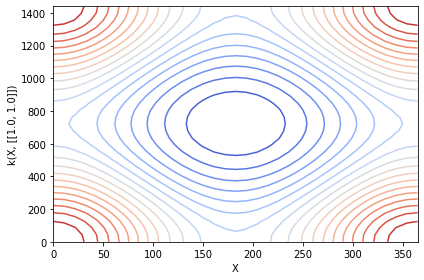

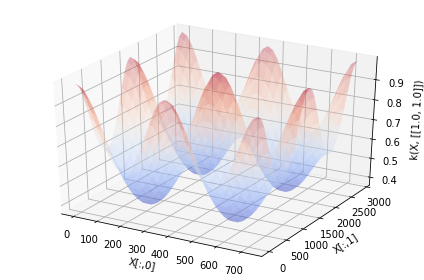

In [6]:
#setting ARD1 true means we get multiple periods for the input dims
periodic = GPy.kern.StdPeriodic(2 , ARD1 = True, period = (365,1440))

#plotting 
periodic.plot_covariance(plot_limits = (0,365, 0, 1440), cmap= 'coolwarm')
periodic.plot_covariance(projection = '3d', plot_limits = (0,730, 0, 2880), cmap= 'coolwarm')


A visualization of the periodic kernel. 

{'covariance': [<mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7f9848af4da0>]}

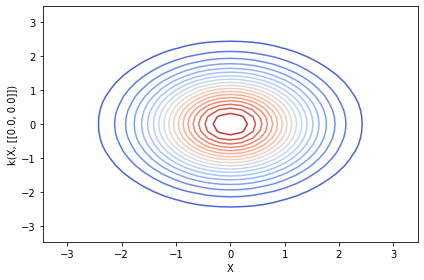

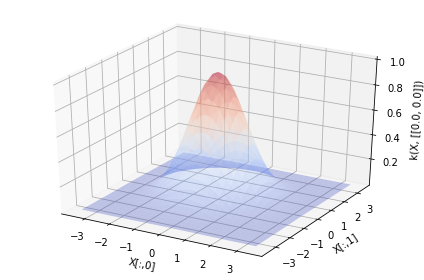

In [7]:
##The default kernel 

default = GPy.kern.RBF(2)
default.plot_covariance(cmap= 'coolwarm')
default.plot_covariance(projection = '3d', cmap= 'coolwarm')

The default kernel is a single centered 2d radial basis function that is based on a Gaussian.

In [8]:
## calculating the mean squared error
def mse(model, x_test, y_test):
    Y_predict = model.predict(x_test)[0]
    mse = ((Y_predict - y_test)**2).mean()
    
    return mse

In [11]:
### Comparing the two Kernels
#get the times
start_sgp = time.time()
sgp_default = GPy.models.SparseGPRegression(x_2d_sample, sample_temp, num_inducing=5)
sgp_default.optimize('bfgs')
time_rbf = time.time() - start_sgp
print('Testing RBF Kernel')
print(sgp_default)
print(f"MSE: {mse(sgp_default, x_2d_cv, y_s_cv)}; Time: {time_rbf}")

start_sgp = time.time()
sgp_periodic = GPy.models.SparseGPRegression(x_2d_sample, sample_temp, kernel = periodic, num_inducing=5)
sgp_periodic.optimize('bfgs')
time_periodic = time.time() - start_sgp
print('\n Testing Periodic Kernel')
print(sgp_periodic)
print(f"MSE: {mse(sgp_periodic, x_2d_cv, y_s_cv)}; Time: {time_periodic}")

Testing RBF Kernel

Name : sparse_gp
Objective : 19775.481714486876
Number of Parameters : 13
Number of Optimization Parameters : 13
Updates : True
Parameters:
  sparse_gp.               |                   value  |  constraints  |  priors
  inducing_inputs          |                  (5, 2)  |               |        
  rbf.variance             |  1.5719649710475866e-06  |      +ve      |        
  rbf.lengthscale          |      0.9999999333929489  |      +ve      |        
  Gaussian_noise.variance  |       159.5453985891703  |      +ve      |        
MSE: 169.075782911104; Time: 6.640743017196655

 Testing Periodic Kernel

Name : sparse_gp
Objective : 14987.08116569966
Number of Parameters : 15
Number of Optimization Parameters : 15
Updates : True
Parameters:
  sparse_gp.                |               value  |  constraints  |  priors
  inducing_inputs           |              (5, 2)  |               |        
  std_periodic.variance     |   7731.919873338093  |      +ve      |     

The result is clear. 

I will continue using the Periodic Kernel because it outperforms the RBF kernel both on the MSE and the time it took to train.

#### Comparing the runtime and the MSE of different periods and lengthscales

In [12]:
#test out four different periods for the years
#the periods correspond ot a month, one season (3 months), and the full year and 1.5 years. 
periods_years = [30, 90, 365, 450]

for period_year in periods_years: 
    
    print(f'Testing first period of {period_year} days')
    periodic = GPy.kern.StdPeriodic(2 , ARD1 = True, period = (period_year,1440))
    
    start_sgp = time.time()
    sgp = GPy.models.SparseGPRegression(x_2d_sample, sample_temp, kernel = periodic, num_inducing= 2)
    sgp.optimize('bfgs')
    
    time_periodic = time.time() - start_sgp
    print(f"MSE: {mse(sgp, x_2d_cv, y_s_cv)}; Time: {time_periodic}")

Testing first period of 30 days
MSE: 54.438767536662766; Time: 18.12969207763672
Testing first period of 90 days


 //anaconda3/lib/python3.7/site-packages/GPy/kern/src/standard_periodic.py:131: RuntimeWarning:overflow encountered in true_divide
 //anaconda3/lib/python3.7/site-packages/GPy/kern/src/standard_periodic.py:132: RuntimeWarning:invalid value encountered in sin
 //anaconda3/lib/python3.7/site-packages/GPy/kern/src/standard_periodic.py:148: RuntimeWarning:overflow encountered in true_divide
 //anaconda3/lib/python3.7/site-packages/GPy/kern/src/standard_periodic.py:150: RuntimeWarning:invalid value encountered in sin
 //anaconda3/lib/python3.7/site-packages/GPy/kern/src/standard_periodic.py:153: RuntimeWarning:invalid value encountered in cos
 //anaconda3/lib/python3.7/site-packages/GPy/kern/src/standard_periodic.py:181: RuntimeWarning:overflow encountered in true_divide
 //anaconda3/lib/python3.7/site-packages/GPy/kern/src/standard_periodic.py:181: RuntimeWarning:invalid value encountered in multiply
 //anaconda3/lib/python3.7/site-packages/GPy/kern/src/standard_periodic.py:181: RuntimeWar

MSE: 25.794223022462653; Time: 29.417197942733765
Testing first period of 365 days
MSE: 25.799711505348082; Time: 16.200368881225586
Testing first period of 450 days
MSE: 26.08724050417558; Time: 72.83038210868835


The best MSE was with the period of 365 days.

In [13]:
#test out four different for the daily variation
#the periods correspond to an hourly, a day time (morning, midday, evening, night), and day variation.
periods_day = [60, 360, 1440, 2000]

for period_day in periods_day: 
    
    print(f'Testing second order period of {period_day} minutes')
    periodic = GPy.kern.StdPeriodic(2 , ARD1 = True, period = (365,period_day))
    
    start_sgp = time.time()
    sgp = GPy.models.SparseGPRegression(x_2d_sample, sample_temp, kernel = periodic, num_inducing=2)
    sgp.optimize('bfgs')
    
    time_periodic = time.time() - start_sgp
    print(f"MSE: {mse(sgp, x_2d_cv, y_s_cv)}; Time: {time_periodic}")

Testing second order period of 60 minutes
MSE: 28.730663919913038; Time: 22.89249300956726
Testing second order period of 360 minutes
MSE: 28.691786011836736; Time: 16.187530040740967
Testing second order period of 1440 minutes
MSE: 25.79954285603749; Time: 16.545176029205322
Testing second order period of 2000 minutes
MSE: 26.011626129570388; Time: 25.92548704147339


Again, the prediction has the best MSE so we will use 1440 as the second period. 

In [14]:
#test out three different for different length scales
#the length scale corresponds to how far away a input point has to be from another to be significantly correlated with it
scales = [1, 10, 30]

for ls in scales: 
    
    print(f'Testing first dim length scale of {ls}')
    periodic = GPy.kern.StdPeriodic(2 , ARD1 = True, ARD2 = True, period = (365,1440), lengthscale = (ls, 1))
    
    start_sgp = time.time()
    sgp = GPy.models.SparseGPRegression(x_2d_sample, sample_temp, kernel = periodic, num_inducing=2)
    sgp.optimize('bfgs')
    
    time_periodic = time.time() - start_sgp
    print(f"MSE: {mse(sgp, x_2d_cv, y_s_cv)}; Time: {time_periodic}")

Testing first dim length scale of 1
MSE: 25.875172555431526; Time: 33.32016205787659
Testing first dim length scale of 10
MSE: 25.776710684388263; Time: 30.942809104919434
Testing first dim length scale of 30
MSE: 25.87513363340454; Time: 28.281148195266724


In [15]:
## so the using a large ls did harm. let's see what happens in smaller increments

scales = [1, 3, 5]

for ls in scales: 
    
    print(f'Testing first dim length scale of {ls}')
    periodic = GPy.kern.StdPeriodic(2 , ARD1 = True, ARD2 = True, period = (365,1440), lengthscale = (ls, 1))
    
    start_sgp = time.time()
    sgp = GPy.models.SparseGPRegression(x_2d_sample, sample_temp, kernel = periodic, num_inducing=2)
    sgp.optimize('bfgs')
    
    time_periodic = time.time() - start_sgp
    print(f"MSE: {mse(sgp, x_2d_cv, y_s_cv)}; Time: {time_periodic}")

Testing first dim length scale of 1
MSE: 25.645959386521884; Time: 73.20949912071228
Testing first dim length scale of 3
MSE: 25.875005191910937; Time: 24.043397188186646
Testing first dim length scale of 5
MSE: 54.7347095224044; Time: 11.410506963729858


In [16]:
scales = [1, 3, 10, 60]

for ls in scales: 
    
    print(f'Testing second dim length scale of {ls}')
    periodic = GPy.kern.StdPeriodic(2 , ARD1 = True, ARD2 = True, period = (365,1440), lengthscale = (1, ls))
    
    start_sgp = time.time()
    sgp = GPy.models.SparseGPRegression(x_2d_sample, sample_temp, kernel = periodic, num_inducing=2)
    sgp.optimize('bfgs')
    
    time_periodic = time.time() - start_sgp
    print(f"MSE: {mse(sgp, x_2d_cv, y_s_cv)}; Time: {time_periodic}")

Testing second dim length scale of 1
MSE: 25.874662169423253; Time: 27.326384782791138
Testing second dim length scale of 3
MSE: 28.785141662075414; Time: 19.234299898147583
Testing second dim length scale of 10
MSE: 25.872549303255347; Time: 37.87587094306946
Testing second dim length scale of 60


 //anaconda3/lib/python3.7/site-packages/GPy/kern/src/standard_periodic.py:161: RuntimeWarning:invalid value encountered in multiply
 //anaconda3/lib/python3.7/site-packages/GPy/kern/src/standard_periodic.py:166: RuntimeWarning:invalid value encountered in multiply
 //anaconda3/lib/python3.7/site-packages/GPy/kern/src/standard_periodic.py:181: RuntimeWarning:invalid value encountered in true_divide


MSE: 37.97270347776402; Time: 5.156164169311523


For both length scales, the default setting of a length scale of 1, yielded the best MSE. 


### Inducing points

Now that we have chosen the length scales, we can validate different numbers of inducing points. This will increase the run time as the sparse GP runs on $O(n*m^2)$, so only a couple of different numbers will be used. 

In [17]:
run_times = []
MSEs = []

inducing = [2,5,15,30,50,100]

for number in inducing: 
    
    print(f'Testing {number} inducing points')
    periodic = GPy.kern.StdPeriodic(2 , ARD1 = True, period = (365,1440))
    
    start_sgp = time.time()
    sgp = GPy.models.SparseGPRegression(x_2d_sample, sample_temp, kernel = periodic, num_inducing= number)
    sgp.optimize('bfgs')
    
    time_periodic = time.time() - start_sgp
    run_times.append(time_periodic)
    MSEs.append(mse(sgp, x_2d_cv, y_s_cv))
    print(f"MSE: {MSEs[-1]}; Time: {time_periodic}")

Testing 2 inducing points
MSE: 25.794896859560044; Time: 16.138890266418457
Testing 5 inducing points


 //anaconda3/lib/python3.7/site-packages/GPy/kern/src/standard_periodic.py:132: RuntimeWarning:overflow encountered in sin
 //anaconda3/lib/python3.7/site-packages/GPy/kern/src/standard_periodic.py:150: RuntimeWarning:overflow encountered in sin
 //anaconda3/lib/python3.7/site-packages/GPy/kern/src/standard_periodic.py:153: RuntimeWarning:overflow encountered in cos
 //anaconda3/lib/python3.7/site-packages/GPy/kern/src/standard_periodic.py:153: RuntimeWarning:overflow encountered in true_divide


MSE: 25.916974326486823; Time: 101.6181070804596
Testing 15 inducing points
MSE: 25.218683720424135; Time: 39.08248519897461
Testing 30 inducing points
MSE: 25.17089485028677; Time: 42.196927309036255
Testing 50 inducing points
MSE: 25.320065922904625; Time: 26.94814705848694
Testing 100 inducing points
MSE: 25.327547111610766; Time: 28.764370918273926


Text(0, 0.5, 'Runtime (s)')

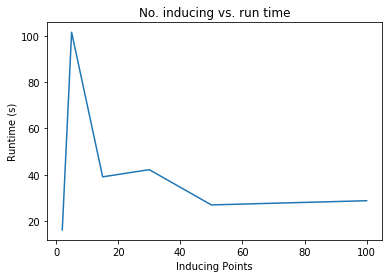

In [18]:
plt.plot(inducing, run_times)
plt.title("No. inducing vs. run time")
plt.xlabel("Inducing Points")
plt.ylabel("Runtime (s)")

Text(0, 0.5, 'MSE')

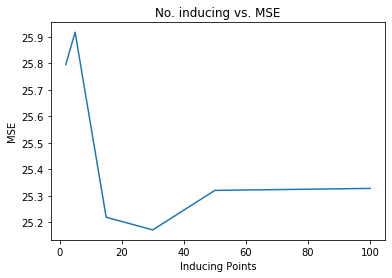

In [19]:
plt.plot(inducing, MSEs)
plt.title("No. inducing vs. MSE")
plt.xlabel("Inducing Points")
plt.ylabel("MSE")

It seems like the best MSE is achieved between 5 and 30 inducing points. I will try a finer grain again and see if I can improve the MSE even more. 

In [ ]:
run_times_fine = []
MSEs_fine = []

inducing = [5, 12,15,17, 25,]

for number in inducing: 
    
    print(f'Testing {number} inducing points')
    periodic = GPy.kern.StdPeriodic(2 , ARD1 = True, period = (365,1440))
    
    start_sgp = time.time()
    sgp = GPy.models.SparseGPRegression(x_2d_sample, sample_temp, kernel = periodic, num_inducing= number)
    sgp.optimize('bfgs')
    
    time_periodic = time.time() - start_sgp
    run_times_fine.append(time_periodic)
    MSEs_fine.append(mse(sgp, x_2d_cv, y_s_cv))
    print(f"MSE: {MSEs_fine[-1]}; Time: {time_periodic}")

Testing 5 inducing points
MSE: 25.9167113401316; Time: 60.9545841217041
Testing 12 inducing points
MSE: 25.325323815901204; Time: 87.12307500839233
Testing 15 inducing points
MSE: 25.211151033643596; Time: 56.96404409408569
Testing 17 inducing points


In [ ]:
plt.plot(inducing, run_times_fine)
plt.title("No. inducing vs. run time")
plt.xlabel("Inducing Points")
plt.ylabel("Runtime (s)")

In [ ]:
plt.plot(inducing, MSEs_fine)
plt.title("No. inducing vs. MSE")
plt.xlabel("Inducing Points")
plt.ylabel("MSE")

#### Final call: 
- StdPeriodic Kernel
- Periods of 365 days and 1440 minutes
- Lengthscale at the default parameters
- 15 inducing points to get the best trade-off between run time and MSE. 

Comparing in the different input-parameters is difficult due to the computational constraint. If there was more computational power, I would go for finer grains of comparisons and also run it multiple times to increase the representativeness of the results. This would e.g. mean re-sampling the data 30 times and cross-validating the times and the MSE. The aggregate from the different trials could be used to make the final decision.

## Comparing to LPM

I will use different input sizes to compare the runtime and the MSE of the LPM and the Sparse GP Regression.

In [ ]:
#final
periodic = GPy.kern.StdPeriodic(2 , ARD1 = True, period = (365,1440))

start_sgp = time.time()
sgp = GPy.models.SparseGPRegression(x_2d_sample, sample_temp, kernel = periodic, num_inducing=15)
sgp.optimize('bfgs')
print("Running the sparse GP took", time.time() - start_sgp, "seconds")

In [ ]:
#include the cv-set back into the training data
train_full = df[df['year'] < 2016]

#convert the train-data frame into arrays
x_day = np.asarray(train_full['day']).reshape(-1,1)
x_time = np.asarray(train_full['min']).reshape(-1,1)
y_s = np.asarray(train_full['temp']).reshape(-1, 1)

In [ ]:
length_train_data = len(x_day)

sample_days = []
sample_time = []
sample_temp = []

for i in range(10000):
    
    #make sure we have new data points every time (this also means I get the same result when running this)
    rd.seed(i)
    
    #get an index 
    index = rd.randint(0, length_train_data - 1)

    #sample it
    sample_days.append(x_day[index])
    sample_time.append(x_time[index])
    sample_temp.append(y_s[index])
    
sample_days = np.asarray(sample_days).reshape(-1,1)
sample_time = np.asarray(sample_time).reshape(-1,1)
sample_temp = np.asarray(sample_temp).reshape(-1,1)

In [ ]:
x_2d_sample = np.concatenate((sample_days, sample_time), axis =1 )

In [ ]:
#set up some alphas for the CV Ridge regression
alphas = [10**i for i in range(-8,2,1)]

In [ ]:
time_lpm = []
time_sgp = []

mse_lpm = []
mse_sgp = []

for input_size in range(1000,10001,1000):
    
    
    ## do the LMP
    LPM =  linear_model.RidgeCV(alphas = alphas)
    
    start_lpm = time.time()
    
    #restrict the input length
    LPM.fit(x_2d_sample[:input_size], sample_temp[:input_size])
    
    time_lpm.append(time.time()-start_lpm)
    mse_lpm.append(mse(LPM, x_2d_test, y_s_test))
    
    # do the GP
    start_sgp = time.time()
    sgp = GPy.models.SparseGPRegression(x_2d_sample[:input_size], sample_temp[:input_size], kernel = periodic, num_inducing=15)
    sgp.optimize('bfgs')
    
    time_sgp.append(time.time() - start_sgp)
    mse_sgp.append(mse(sgp, x_2d_test, y_s_test))

In [ ]:
#compare the models on MSE
plt.plot(list(range(1000,10001,1000)), mse_lpm)
plt.plot(list(range(1000,10001,1000)), mse_sgp)
plt.xlabel('n')
plt.ylabel('MSE')
plt.legend(['LPM', 'Sparse GP'])


#compare the models on MSE
plt.figure()
plt.plot(list(range(1000,10001,1000)), mse_sgp, color = 'orange')
plt.xlabel('n')
plt.ylabel('MSE')
plt.legend(['LPM', 'Sparse GP'])

In [ ]:
#min LPM MSE
print('Min LPM MSE :', mse_lpm[np.argmin(mse_lpm)])

#min SGP MSE
print('Min SGP MSE :',mse_sgp[np.argmin(mse_sgp)])

In [ ]:
#compare the two models
plt.plot(list(range(1000,10001,1000)), time_lpm)
plt.plot(list(range(1000,10001,1000)), time_sgp)
plt.xlabel('n')
plt.ylabel('Run time')
plt.legend(['LPM', 'Sparse GP'])

plt.figure()
plt.plot(list(range(1000,10001,1000)), time_lpm)
plt.xlabel('n')
plt.ylabel('Run time')
plt.legend(['LPM', 'Sparse GP'])

As shown above the increase in time for the Sparse GP is non-linear and shows clearly how the Sparse Gaussian outperforms the LPM when measured on the mean squared error of the test predictions. Hence, the accuracy of the SGP predictions is significantly better than that of the LPM. 

However, when looking at the run-time we see that the SGP performs much worse and increases to a maximum of over 10 minutes when being trained on the 10^4 n training data. While both training times increase, the SGP increases in a non-linear fashion. To be precise we expect a complexity of $O(n*m^2)$.



## Plotting

In [ ]:
#had to set the legend to false because it produced an error that according to stack-overflow is due to some package internal bug. 
sgp.plot_f(cmap = 'coolwarm')
sgp.plot_f(projection = '3d', legend = False, cmap = 'coolwarm',alpha = .1)


print(sgp)

Final Figures: Both are 3d representations of the Sparse Gaussian Process function. The more yellow the warmer the temperature. For the contour plot the x-axis shows the yearly variation and y-axis shows the daily variation. In the 3D plot, the bottom-left axis shows the yearly variation in days and the bottom-right axis the daily variation in minutes.

The plots above show how the SparseGP is a variation of the periodic kernel from above. There is a center of heat during at around 800 minutes (i.e. around 1PM) and around 225 days, which is during roughly the 7th month, i.e., July. Hence, the plot shows that the warmest time at noon during the summer which is definitely plausible. As already seen in Assignment 3 the variation during the year is much more pronounced and explains much more of the temperature change than the time of day

## Works Cited

SheffieldML. (2015). GPy. Retrieved March 27, 2020, from https://gpy.readthedocs.io/en/deploy/index.html

Open Data Science Initiative. (2014, January 15). James Hensman: Sparse Gaussian Processes. Retrieved March 27, 2020, from https://www.youtube.com/watch?v=66vH34Ykfo0